## Lead Scoring Case Study

- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. 
- A higher score would mean that the lead is hot and  is most likely to converted.
- A lower score would mean that the lead is cold and will mostly not get converted.

### Reading and understanding the data

In [123]:
## Importing Required Libraries

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas and NumPy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

In [124]:
# Importing  datasets
leadScore = pd.read_csv("Leads.csv")
leadScore.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Inspecting the Dataframe

In [125]:
# Let's check the dimensions of the dataframe
leadScore.shape


(9240, 37)

In [126]:
## Actual Row Count
rowCount = leadScore.shape[0]
rowCount

9240

In [127]:
leadScore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [128]:
leadScore.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


### Data Cleaning

- Handling Select
- Converting some binary variables (Yes/No) to 0/1
- For categorical variables with multiple levels, create dummy features (one-hot encoded)
- Dropping of high %age of Missing Values
- Unique Categories in the Categorical Columns
- Imputation Techinques
- Percentage of row retained .

#### Handling Select Level in Categorical Columns

In [129]:
#finding the list of columns containing  the select value
series_value= leadScore.columns.to_series().groupby(leadScore.dtypes).groups
dic={k.name: v for k, v in series_value.items()}
columns=dic['object']
select_columns=[]
for i in enumerate(columns):
    values=leadScore[i[1]].str.contains('Select', case=False, na=False).sum()
    if values>0:
        print(f"Column {i[1]} contains {values} select values ")
        select_columns.append(i[1])

Column Specialization contains 1942 select values 
Column How did you hear about X Education contains 5043 select values 
Column Lead Profile contains 4146 select values 
Column City contains 2249 select values 


### Based on the analysis replacing the select values as below

##### Specialisation = The industry domain in which the customer worked before. 
- Replacing "Select" as "Others" in the Specilaizaion varibales

#####  How did you hear about X Education = The source from which the customer heard about X Education.
- Replacing "Select" as "X Education Forums" in the How did you hear about X Education varibales

##### Lead Profile = A lead level assigned to each customer based on their profile.
- Replacing "Select" as "SpecialLead" in the Lead Profile varibales

#####  City = The city of the customer.
- Replacing "Select" as "CityCenter" in the City varibales


In [130]:
# Replacing the select values 
select_columns
value_change={"Specialization":'Others',
              "How did you hear about X Education":'X Education Forums'
              ,"Lead Profile":'SpecialLead'
              ,"City":'CityCenter'}
for i in enumerate(select_columns):
    leadScore[i[1]].replace(['Select'],[value_change[i[1]]],inplace=True)

In [131]:
# Rechecking whether any select value is present in the table
series_value= leadScore.columns.to_series().groupby(leadScore.dtypes).groups
dic={k.name: v for k, v in series_value.items()}
columns=dic['object']
select_columns=[]
for i in enumerate(columns):
    values=leadScore[i[1]].str.contains('Select', case=False, na=False).sum()
    if values>0:
        print(f"Column {i[1]} contains {values} select values ")
        select_columns.append(i[1])
if len(select_columns)==0:
    print('select values are re-placed Successfully')

select values are re-placed Successfully


#### Converting some binary variables (Yes/No) to 0/1

In [132]:
leadScore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [133]:
# List of variables to map

varlist =  ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque','A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
leadScore[varlist] = leadScore[varlist].apply(binary_map)

leadScore.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,...,0,SpecialLead,CityCenter,02.Medium,02.Medium,15.0,15.0,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,...,0,SpecialLead,CityCenter,02.Medium,02.Medium,15.0,15.0,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,...,0,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,...,0,SpecialLead,Mumbai,02.Medium,01.High,13.0,17.0,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,...,0,SpecialLead,Mumbai,02.Medium,01.High,15.0,18.0,0,0,Modified


#### Dropping of high Percenatge of Missing Values

In [134]:
## Checking for Duplicate records
leadScore[leadScore.duplicated()]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


In [135]:
# Checking the percentage of missing values
round(100*(leadScore.isnull().sum()/len(leadScore.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

### Imputation Techniques to handle Missing Values

- Dropping the Columns having more than 35% of Missing values
- removing misingvalues of the Columns having < 2% of Missing Values
- FIlling 'Others' for the rest of the columns having > 2 % to < 35% of Missing values

In [136]:
# Dropping the columns having more than 35% of missing Values

leadScore = leadScore.drop(['Tags','Lead Quality','Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score'], axis = 1) 
leadScore.head()


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,...,0,0,0,0,0,SpecialLead,CityCenter,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,...,0,0,0,0,0,SpecialLead,CityCenter,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,...,0,0,0,0,0,Potential Lead,Mumbai,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,...,0,0,0,0,0,SpecialLead,Mumbai,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,...,0,0,0,0,0,SpecialLead,Mumbai,0,0,Modified


In [137]:
# Removing NaN Lead Source ,TotalVisits,Page Views Per Visit & Last Activity rows

leadScore = leadScore[~leadScore['Lead Source'].isnull()]
leadScore = leadScore[~np.isnan(leadScore['TotalVisits'])]
leadScore = leadScore[~np.isnan(leadScore['Page Views Per Visit'])]

# Filling 'Others' to below mentioned Columns

leadScore[['Country','Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course','Lead Profile','City']] = leadScore[['Country','Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course','Lead Profile','City']].fillna(value='Others')
round(100*(leadScore.isnull().sum()/len(leadScore.index)), 2)

# Checking the percentage of missing values
round(100*(leadScore.isnull().sum()/len(leadScore.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
How did you hear about X Education               0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                             

#### Unique Categories in the Categorical Columns

In [138]:
# Finding the object columns
series_value= leadScore.columns.to_series().groupby(leadScore.dtypes).groups
dic={k.name: v for k, v in series_value.items()}
column_obj=list(dic['object'])
len(column_obj)
column_obj.remove('Prospect ID')

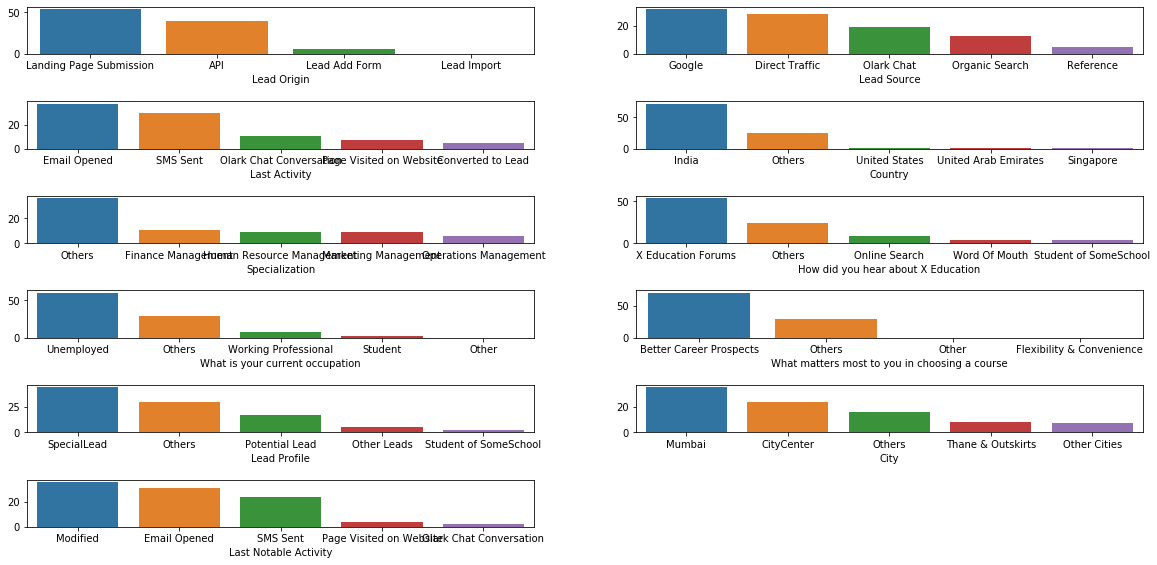

In [139]:
## displaying top five value count for each variables
plt.figure(figsize = (20, 20))
for i in enumerate(column_obj):
    plt.subplot(12,2,i[0]+1)
    plt.subplots_adjust( hspace=1)
    plt.xlabel(i[1])
    sns.barplot(((leadScore[i[1]].value_counts()/leadScore[i[1]].count())*100)[:5,].index,
                ((leadScore[i[1]].value_counts()/leadScore[i[1]].count())*100)[:5,].values)

#### Based on the above graph,The treshold percentage is set and the value to be replaced is fixed in the dic

In [140]:
# Creating Dic to replace the values after the threshold values
dic_replace={"Lead Origin":[30,'Other Lead Origin'],
"Lead Source":[10,'Other Source'],
"Last Activity":[10,'Other Activity'],
"Country":[20,'Other country'],
"Specialization":[10,'Other Specialization'],
"How did you hear about X Education":[10,'Other Resourses'],
"What is your current occupation":[10,'Other occupation'],
"What matters most to you in choosing a course":[10,'Other choosing'],
"Lead Profile":[10,'Other Lead profile'],
"City":[10,'Other city'],
"Last Notable Activity":[10,'Other Notable Activity']}

In [141]:
#  Function to replace all the catar variables
for i in enumerate(column_obj):
    Lead_replace=pd.DataFrame((((((leadScore[i[1]].value_counts()/leadScore[i[1]].count())*100)>dic_replace[i[1]][0])).reset_index()))
    Lead_replace.columns=['Lead Origin','Result']
    list_false=Lead_replace['Lead Origin'][Lead_replace['Result']==False].values
    for j in enumerate(list_false):
        leadScore[i[1]].replace([j[1]],[dic_replace[i[1]][1]],inplace=True)

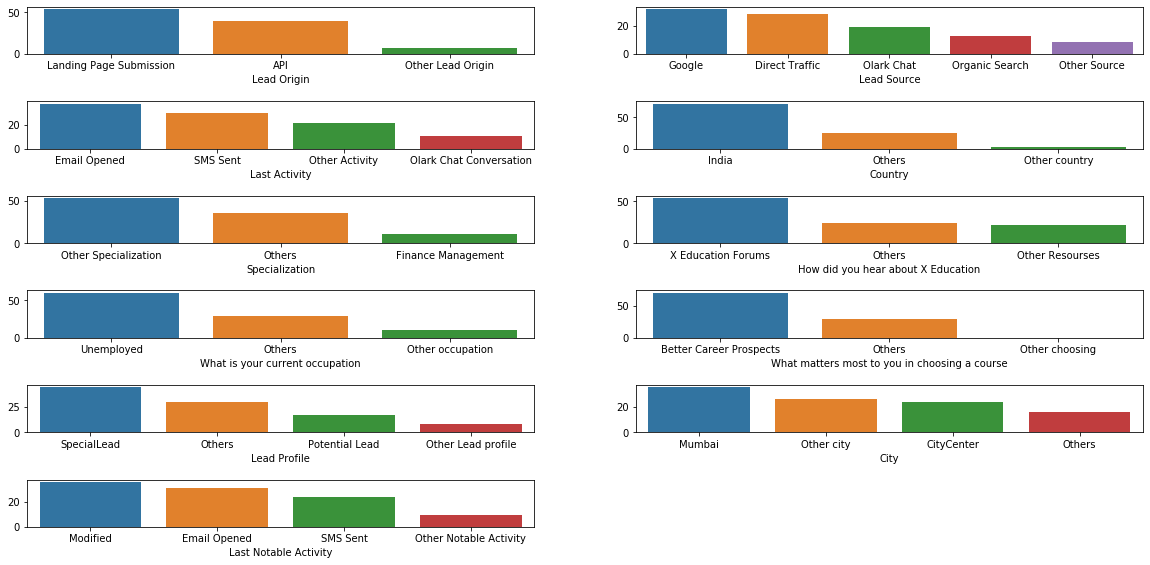

In [142]:
## displaying top five value count for each variables after the replacement
plt.figure(figsize = (20, 20))
for i in enumerate(column_obj):
    plt.subplot(12,2,i[0]+1)
    plt.subplots_adjust( hspace=1)
    plt.xlabel(i[1])
    sns.barplot(((leadScore[i[1]].value_counts()/leadScore[i[1]].count())*100)[:5,].index,
                ((leadScore[i[1]].value_counts()/leadScore[i[1]].count())*100)[:5,].values)

### Finding the outliers

In [143]:
leadScore.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
count,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.0,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.0,9074.0,9074.0,9074.0,9074.000000
mean,617032.619352,0.078907,0.000220,0.378554,3.456028,482.887481,2.370151,0.001543,0.0,0.000220,0.000110,0.000110,0.000441,0.000771,0.0,0.0,0.0,0.0,0.318272
std,23348.029512,0.269608,0.014845,0.485053,4.858802,545.256560,2.160871,0.039251,0.0,0.014845,0.010498,0.010498,0.020992,0.027766,0.0,0.0,0.0,0.0,0.465831
min,579533.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,596406.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
50%,615278.500000,0.000000,0.000000,0.000000,3.000000,246.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
75%,637176.500000,0.000000,0.000000,1.000000,5.000000,922.750000,3.200000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
95%,655344.450000,1.000000,0.000000,1.000000,10.000000,1557.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
99%,659563.350000,1.000000,0.000000,1.000000,17.000000,1839.000000,9.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
max,660737.000000,1.000000,1.000000,1.000000,251.000000,2272.000000,55.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000


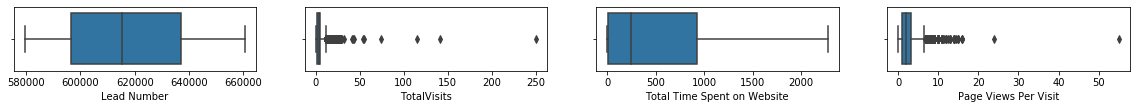

In [144]:
## checking for the outliers
plt.figure(figsize = (20, 20))
feature = ['Lead Number', 'TotalVisits','Total Time Spent on Website',
           'Page Views Per Visit']
for i in enumerate(feature):
    plt.subplot(9,4,i[0]+1)
    plt.subplots_adjust( hspace=1)
    sns.boxplot(leadScore[i[1]])

### Treating Outlier : 
- Impact  : May give misleading results .
- Decision  : We believe dropping data is always a harsh step and should be taken only in extreme conditions when    we’re very sure that the outlier is a measurement error, which we generally do not know.When we drop data, we lose information in terms of the variability in data. Hence we can Cap them.
        
    

In [145]:
## Capping  : I have less outlier 

q1 = leadScore['TotalVisits'].quantile(0.01)
q4 = leadScore['TotalVisits'].quantile(0.99)

leadScore['TotalVisits'][leadScore['TotalVisits'] <= q1] = q1
leadScore['TotalVisits'][leadScore['TotalVisits'] >= q4] = q4

q1 = leadScore['Page Views Per Visit'].quantile(0.01)
q4 = leadScore['Page Views Per Visit'].quantile(0.99)


leadScore['Page Views Per Visit'][leadScore['Page Views Per Visit'] <= q1] = q1
leadScore['Page Views Per Visit'][leadScore['Page Views Per Visit'] >= q4] = q4

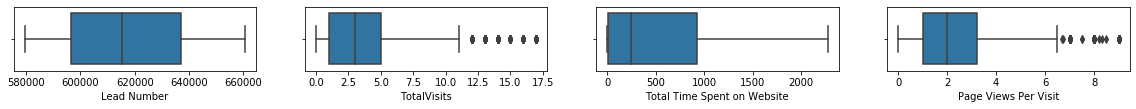

In [146]:
# Rechecking for the outliers
plt.figure(figsize = (20, 20))
feature = ['Lead Number', 'TotalVisits','Total Time Spent on Website',
           'Page Views Per Visit']
for i in enumerate(feature):
    plt.subplot(9,4,i[0]+1)
    plt.subplots_adjust( hspace=1)
    sns.boxplot(leadScore[i[1]])

##### Therefore, After treating the outlier using Capping Method, still we can see few more outliers. Now we need to take a call on whether to keep the outlier or remove the outliers. We already know  that  removing data's may lead to weaken the model and less outliers - hence we decided to keep the outlier without removing them from the dataset for my better Analysis/Model.


In [150]:
## Row Count after Data Cleaning

currentRowCount = leadScore.shape[0]
currentRowCount

9074

In [152]:
## Percetageof row count after data cleaning

PerRowCount = currentRowCount/rowCount * 100
print('percenatge of row count after Data Clean :',PerRowCount)

percenatge of row count after Data Clean : 98.2034632034632


## Data Preparation
    
- For all categorical variables with multiple levels, create dummy features (one-hot encoded)
- Perform train-test split
- PerformScalling

In [153]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(leadScore[['Lead Origin', 'Lead Source', 'Last Activity','Country',
                                   'Specialization',
                                   'How did you hear about X Education',
                                   'What is your current occupation',
                                   'What matters most to you in choosing a course','Lead Profile','City','Last Notable Activity']], drop_first=True)

# Adding the results to the master dataframe
leadScore = pd.concat([leadScore, dummy1], axis=1)

In [154]:
leadScore.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Other Lead Origin',
       'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Other Source',
  

In [155]:
# We have created dummies for the below variables, so we can drop them

leadScore.drop(columns=['Lead Origin', 'Lead Source', 'Last Activity','Country',
                                   'Specialization',
                                   'How did you hear about X Education',
                                   'What is your current occupation',
                                   'What matters most to you in choosing a course','Lead Profile','City','Last Notable Activity'],inplace=True)

In [156]:
leadScore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 48 columns):
Prospect ID                                                     9074 non-null object
Lead Number                                                     9074 non-null int64
Do Not Email                                                    9074 non-null int64
Do Not Call                                                     9074 non-null int64
Converted                                                       9074 non-null int64
TotalVisits                                                     9074 non-null float64
Total Time Spent on Website                                     9074 non-null int64
Page Views Per Visit                                            9074 non-null float64
Search                                                          9074 non-null int64
Magazine                                                        9074 non-null int64
Newspaper Article                               

## Splitting the model

In [157]:
# Putting feature variable to X
X = leadScore.drop(['Prospect ID','Lead Number','Converted'], axis=1)
X.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,What matters most to you in choosing a course_Others,Lead Profile_Others,Lead Profile_Potential Lead,Lead Profile_SpecialLead,City_Mumbai,City_Other city,City_Others,Last Notable Activity_Modified,Last Notable Activity_Other Notable Activity,Last Notable Activity_SMS Sent
0,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,2.0,1532,2.0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,2.0,1428,1.0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [158]:
# Putting response variable to y
y = leadScore['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [159]:
a=X.columns
a
standard_columns=[]
for i in enumerate(a):
    if X[i[1]].max()>1:
        standard_columns.append(i[1])
standard_columns

['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

In [160]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
train_columns=X_train.columns

### Feature selection

In [161]:
# Scaling the variables
scaler = StandardScaler()
X_train[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']])
X_train.head()
y_train.shape

(6351,)

### Model Building
Let's start by splitting our data into a training set and a test set.

In [162]:
# running our 1st training Model
# Logistic regression model

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6311
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2426.4
Date:                Mon, 20 Jul 2020   Deviance:                       4852.8
Time:                        11:18:50   Pearson chi2:                 6.08e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
const                                                            0.8240      0.334      2.465      0.014       0.169       1.479
Do Not Email                                                    -1.2873      0.183     -7.040      0.000      -1.646      -0.929
Do Not Call                                                     22.1964    5.6e+04      0.000      1.000    -1.1e+05     1.1e+05
TotalVisits                                                      0.2415      0.052      4.674      0.000       0.140       0.343
Total Time Spent on Website                                      1.1134      0.043     26.064      0.000       1.030       1.197
Page Views Per Visit                                            -0.2067      0.059     -3.515      0.000      -0.322      -0.091
Search                                                           0.1824      1.025      0.178      0.859      -1.826       2.191
Magazine                                                     -1.642e-08   3.08e-05     -0.001      1.000   -6.03e-05    6.03e-05
Newspaper Article                                               25.1313   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
X Education Forums                                             -47.8363   1.12e+05     -0.000      1.000    -2.2e+05     2.2e+05
Newspaper                                                      -25.2777   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
Digital Advertisement                                           -0.3646      1.738     -0.210      0.834      -3.770       3.041
Through Recommendations                                          0.9219      1.664      0.554      0.580      -2.340       4.184
Receive More Updates About Our Courses                         1.17e-08   3.69e-05      0.000      1.000   -7.24e-05    7.24e-05
Update me on Supply Chain Content                             7.147e-09   3.57e-05      0.000      1.000      -7e-05       7e-05
Get updates on DM Content                                    -1.535e-09   1.07e-05     -0.000      1.000    -2.1e-05     2.1e-05
I agree to pay the amount through cheque                     -1.045e-09   2.46e-05  -4.24e-05      1.000   -4.83e-05    4.83e-05
A free copy of Mastering The Interview                          -0.0911      0.147     -0.620      0.535      -0.379       0.197
Lead Origin_Landing Page Submission                             -0.6715      0.173     -3.881      0.000      -1.011      -0.332
Lead Origin_Other Lead Origin                                    2.4821      0.448      5.541      0.000       1.604       3.360
Lead Source_Google                                               0.2397      0.129      1.861      0.063      -0.013

## Feature Selection Using RFE

In [163]:
logreg = LogisticRegression()
rfe = RFE(logreg, 15)             
rfe = rfe.fit(X_train, y_train)

rfe.support_

array([ True, False, False,  True, False, False, False,  True, False,
        True, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False,  True, False,  True, False,
        True, False, False, False, False, False,  True, False,  True,
        True,  True, False, False, False, False,  True, False, False])

In [164]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 9),
 ('TotalVisits', False, 14),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 16),
 ('Search', False, 21),
 ('Magazine', False, 30),
 ('Newspaper Article', True, 1),
 ('X Education Forums', False, 15),
 ('Newspaper', True, 1),
 ('Digital Advertisement', False, 13),
 ('Through Recommendations', False, 17),
 ('Receive More Updates About Our Courses', False, 31),
 ('Update me on Supply Chain Content', False, 27),
 ('Get updates on DM Content', False, 29),
 ('I agree to pay the amount through cheque', False, 28),
 ('A free copy of Mastering The Interview', False, 19),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Other Lead Origin', True, 1),
 ('Lead Source_Google', False, 12),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 23),
 ('Lead Source_Other Source', False, 10),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Other Activity', Fal

In [165]:
col = X_train.columns[rfe.support_]

In [166]:
X_train.columns[~rfe.support_]

Index(['Do Not Call', 'TotalVisits', 'Page Views Per Visit', 'Search',
       'Magazine', 'X Education Forums', 'Digital Advertisement',
       'Through Recommendations', 'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Other Source',
       'Last Activity_Other Activity', 'Country_Other country',
       'Specialization_Other Specialization', 'Specialization_Others',
       'How did you hear about X Education_Others',
       'How did you hear about X Education_X Education Forums',
       'What is your current occupation_Others',
       'What matters most to you in choosing a course_Other choosing',
       'Lead Profile_SpecialLead', 'City_Mumbai', 'City_Other city',
       'City_Others', 'Last Notable Activity_Other Notable Activity',
       'Last Nota

## Finding Correlation of the variables

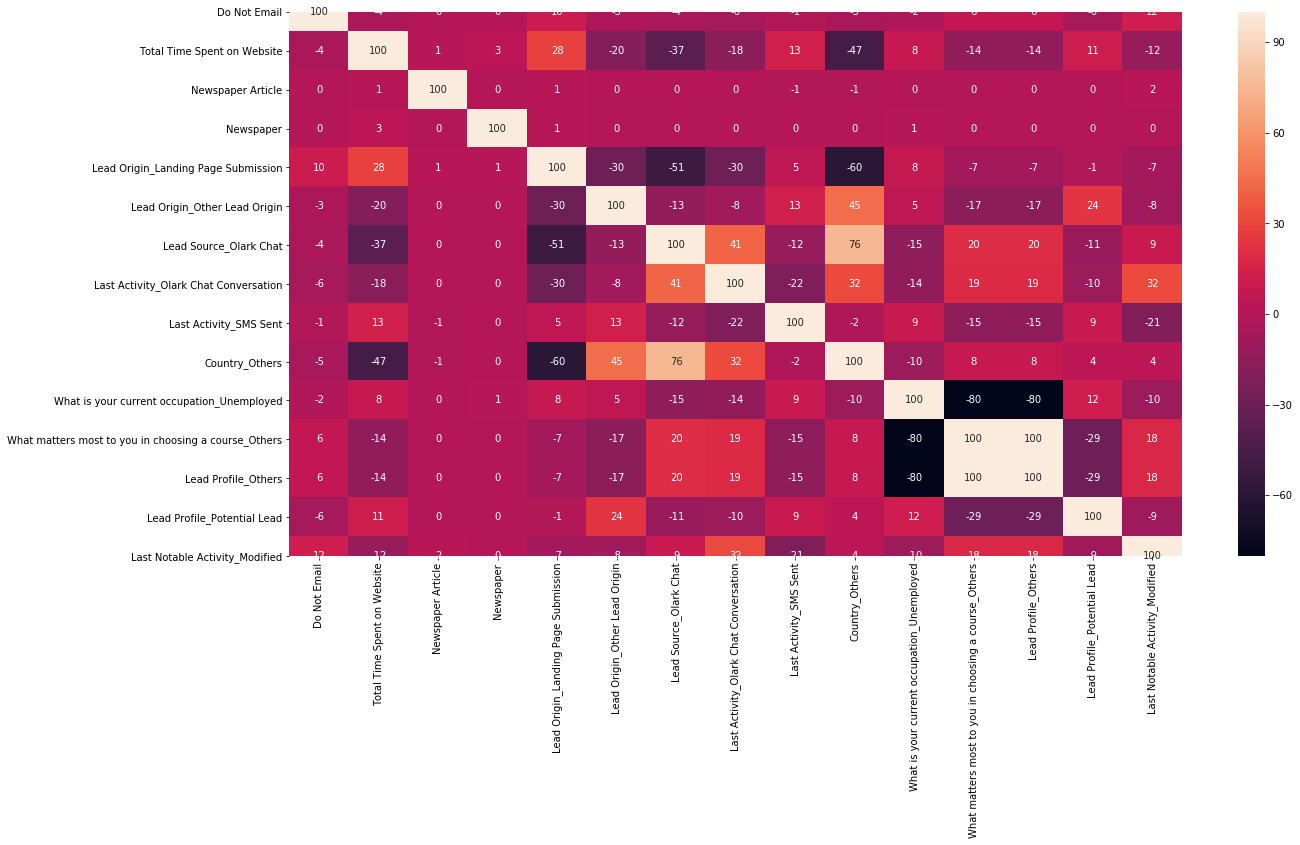

In [167]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap((X_train[col]).corr().mul(100).astype(int),annot = True,fmt='d',annot_kws={"size": 10})
plt.show()

##### Assessing the model with StatsModels

In [168]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2469.8
Date:                Mon, 20 Jul 2020   Deviance:                       4939.6
Time:                        11:19:02   Pearson chi2:                 6.19e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.5335      0.151      3.536      0.000       0.238       0.829
Do Not Email                                            -1.3886      0.176     -7.894      0.000      -1.733      -1.044
Total Time Spent on Website                              1.1286      0.042     26.630      0.000       1.046       1.212
Newspaper Article                                        1.7859      1.492      1.197      0.231      -1.139       4.711
Newspaper                                              -21.9238   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Lead Origin_Landing Page Submission                     -0.3840      0.093     -4.147      0.000      -0.565      -0.202
Lead Origin_Other Lead Origin                            2.9806      0.313      9.532      0.000       2.368       3.593
Lead Source_Olark Chat                                   1.0203      0.269      3.800      0.000       0.494       1.547
Last Activity_Olark Chat Conversation                   -1.0162      0.175     -5.816      0.000      -1.359      -0.674
Last Activity_SMS Sent                                   1.3306      0.078     17.124      0.000       1.178       1.483
Country_Others                                           0.1724      0.264      0.653      0.514      -0.345       0.689
What is your current occupation_Unemployed              -1.5409      0.134    -11.516      0.000      -1.803      -1.279
What matters most to you in choosing a course_Others    -1.2225      0.076    -16.187      0.000      -1.371      -1.074
Lead Profile_Others                                     -1.2225      0.076    -16.187      0.000      -1.371      -1.074
Lead Profile_Potential Lead                              1.6233      0.103     15.791      0.000       1.422       1.825
Last Notable Activity_Modified                          -0.8228      0.084     -9.809      0.000      -0.987      -0.658
========================================================================================================================
"""

In [169]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

3009    0.077534
1012    0.013473
9226    0.423124
4750    0.708838
7987    0.801135
1281    0.725882
2880    0.035912
4971    0.922144
7536    0.845731
1248    0.770875
dtype: float64

In [170]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.07753367, 0.01347266, 0.42312443, 0.70883764, 0.80113546,
       0.72588166, 0.03591163, 0.9221437 , 0.84573141, 0.7708745 ])

##### Creating a dataframe with the actual Converted flag and the predicted probabilities

In [171]:
y_train_pred_final = pd.DataFrame({'Converted':y_train, 'Converted_Prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID
3009,0,0.077534,3009
1012,0,0.013473,1012
9226,0,0.423124,9226
4750,1,0.708838,4750
7987,1,0.801135,7987


##### Creating new column 'predicted' with 1 if Converted_Prob > 0.5 else 0

In [172]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
3009,0,0.077534,3009,0
1012,0,0.013473,1012,0
9226,0,0.423124,9226,0
4750,1,0.708838,4750,1
7987,1,0.801135,7987,1


In [173]:
# Confusion matrix 
cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(cm1)

[[3459  446]
 [ 675 1771]]


In [174]:
#Confusion Matrix

# Actual/Predicted     not_Converted    Converted
#  not_Converted       3459                446
# Converted             675               1771  

In [175]:
# Let's check the overall Logis Regression Model evaluaion
print('Accuracy           : ',metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Sensitivity/Recall : ',metrics.recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Precision          : ',metrics.precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('F1Score            : ',metrics.f1_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Accuracy           :  0.8234923634073374
Sensitivity/Recall :  0.7240392477514309
Precision          :  0.7988272440234552
F1Score            :  0.7595968260776325


#### Checking VIFs

In [176]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,What matters most to you in choosing a course_...,inf
12,Lead Profile_Others,inf
9,Country_Others,14.66
6,Lead Source_Olark Chat,10.97
5,Lead Origin_Other Lead Origin,5.02
10,What is your current occupation_Unemployed,3.08
4,Lead Origin_Landing Page Submission,2.91
14,Last Notable Activity_Modified,1.83
7,Last Activity_Olark Chat Conversation,1.58
8,Last Activity_SMS Sent,1.54


#### There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. 
- The variable 'What matters most to you in choosing a course' & 'Lead Profile_Others' has the Infinity VIF  which is insignifacant .
- The variable 'Country_others ,Lead Source_Clark Chat & Lead Origin_other Lead Origin have the hughest VIF > 5 which is insignifacant .
- So let's start dropping the varibale one by one and rerun the model for betterment.

In [177]:
col = col.drop('What matters most to you in choosing a course_Others', 1)
col

Index(['Do Not Email', 'Total Time Spent on Website', 'Newspaper Article',
       'Newspaper', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Other Lead Origin', 'Lead Source_Olark Chat',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'Country_Others', 'What is your current occupation_Unemployed',
       'Lead Profile_Others', 'Lead Profile_Potential Lead',
       'Last Notable Activity_Modified'],
      dtype='object')

In [178]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2469.8
Date:                Mon, 20 Jul 2020   Deviance:                       4939.6
Time:                        11:19:23   Pearson chi2:                 6.19e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.5335      0.151      3.536      0.000       0.238       0.829
Do Not Email                                  -1.3886      0.176     -7.894      0.000      -1.733      -1.044
Total Time Spent on Website                    1.1286      0.042     26.630      0.000       1.046       1.212
Newspaper Article                              1.7859      1.492      1.197      0.231      -1.139       4.711
Newspaper                                    -21.9238   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Lead Origin_Landing Page Submission           -0.3840      0.093     -4.147      0.000      -0.565      -0.202
Lead Origin_Other Lead Origin                  2.9806      0.313      9.532      0.000       2.368       3.593
Lead Source_Olark Chat                         1.0203      0.269      3.800      0.000       0.494       1.547
Last Activity_Olark Chat Conversation         -1.0162      0.175     -5.816      0.000      -1.359      -0.674
Last Activity_SMS Sent                         1.3306      0.078     17.124      0.000       1.178       1.483
Country_Others                                 0.1724      0.264      0.653      0.514      -0.345       0.689
What is your current occupation_Unemployed    -1.5409      0.134    -11.516      0.000      -1.803      -1.279
Lead Profile_Others                           -2.4450      0.151    -16.187      0.000      -2.741      -2.149
Lead Profile_Potential Lead                    1.6233      0.103     15.791      0.000       1.422       1.825
Last Notable Activity_Modified                -0.8228      0.084     -9.809      0.000      -0.987      -0.658
==============================================================================================================
"""

In [179]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.07753367, 0.01347266, 0.42312443, 0.70883764, 0.80113546,
       0.72588166, 0.03591163, 0.9221437 , 0.84573141, 0.7708745 ])

In [180]:
y_train_pred_final['Converted_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
3009,0,0.077534,3009,0
1012,0,0.013473,1012,0
9226,0,0.423124,9226,0
4750,1,0.708838,4750,1
7987,1,0.801135,7987,1


In [181]:
# Let's check the overall Logis Regression Model evaluaion
print('Accuracy           : ',metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Sensitivity/Recall : ',metrics.recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Precision          : ',metrics.precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('F1Score            : ',metrics.f1_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Accuracy           :  0.8234923634073374
Sensitivity/Recall :  0.7240392477514309
Precision          :  0.7988272440234552
F1Score            :  0.7595968260776325


#### So overall the performance model remain unchanged .

In [182]:
## Lets check VIF again

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,Country_Others,14.66
6,Lead Source_Olark Chat,10.97
5,Lead Origin_Other Lead Origin,5.02
10,What is your current occupation_Unemployed,3.08
4,Lead Origin_Landing Page Submission,2.91
11,Lead Profile_Others,2.25
13,Last Notable Activity_Modified,1.83
7,Last Activity_Olark Chat Conversation,1.58
8,Last Activity_SMS Sent,1.54
1,Total Time Spent on Website,1.35


#### There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. 

- The variable 'Country_others ,Lead Source_Clark Chat & Lead Origin_other Lead Origin have the hughest VIF > 5 which is insignifacant .
- So let's start dropping the varibale one by one and rerun the model for betterment.

In [183]:
# dropping Country_others Varibales becos having of High VIF values
col = col.drop('Country_Others', 1)
col

Index(['Do Not Email', 'Total Time Spent on Website', 'Newspaper Article',
       'Newspaper', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Other Lead Origin', 'Lead Source_Olark Chat',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'What is your current occupation_Unemployed', 'Lead Profile_Others',
       'Lead Profile_Potential Lead', 'Last Notable Activity_Modified'],
      dtype='object')

In [184]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2470.0
Date:                Mon, 20 Jul 2020   Deviance:                       4940.0
Time:                        11:19:33   Pearson chi2:                 6.19e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.5388      0.151      3.577      0.000       0.244       0.834
Do Not Email                                  -1.3871      0.176     -7.889      0.000      -1.732      -1.043
Total Time Spent on Website                    1.1253      0.042     26.749      0.000       1.043       1.208
Newspaper Article                              1.7865      1.492      1.197      0.231      -1.138       4.711
Newspaper                                    -21.9165   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Lead Origin_Landing Page Submission           -0.3855      0.093     -4.166      0.000      -0.567      -0.204
Lead Origin_Other Lead Origin                  3.1409      0.195     16.138      0.000       2.759       3.522
Lead Source_Olark Chat                         1.1752      0.126      9.301      0.000       0.928       1.423
Last Activity_Olark Chat Conversation         -1.0132      0.175     -5.794      0.000      -1.356      -0.670
Last Activity_SMS Sent                         1.3322      0.078     17.157      0.000       1.180       1.484
What is your current occupation_Unemployed    -1.5440      0.134    -11.545      0.000      -1.806      -1.282
Lead Profile_Others                           -2.4467      0.151    -16.199      0.000      -2.743      -2.151
Lead Profile_Potential Lead                    1.6258      0.103     15.826      0.000       1.424       1.827
Last Notable Activity_Modified                -0.8222      0.084     -9.803      0.000      -0.987      -0.658
==============================================================================================================
"""

In [185]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

y_train_pred_final['Converted_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
3009,0,0.077719,3009,0
1012,0,0.013543,1012,0
9226,0,0.420681,9226,0
4750,1,0.708472,4750,1
7987,1,0.800536,7987,1


In [186]:
# Let's check the overall Logis Regression Model evaluaion
print('Accuracy           : ',metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Sensitivity/Recall : ',metrics.recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('Precision          : ',metrics.precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print('F1Score            : ',metrics.f1_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Accuracy           :  0.8233349078885215
Sensitivity/Recall :  0.7244480784955029
Precision          :  0.7981981981981981
F1Score            :  0.7595370767252465


#### So overall the performance model :
- Sensitivity has slight improvement and  other factor remain unchanged .

In [187]:
## Lets check VIF again

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,What is your current occupation_Unemployed,3.08
4,Lead Origin_Landing Page Submission,2.91
10,Lead Profile_Others,2.25
6,Lead Source_Olark Chat,2.06
12,Last Notable Activity_Modified,1.83
7,Last Activity_Olark Chat Conversation,1.58
8,Last Activity_SMS Sent,1.54
5,Lead Origin_Other Lead Origin,1.42
11,Lead Profile_Potential Lead,1.35
1,Total Time Spent on Website,1.32


#### All the variables have  VIF less than 5.

#### So overall the performance model :
- Sensitivity has slight improvement and  other factors.

Text(0.5, 0, 'Errors')

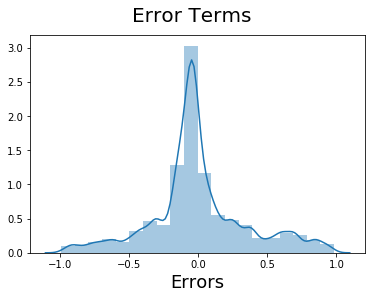

In [188]:
## Performig Residual Analysis
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

#  Train Model Observation :
- VIF of all features are < 5 cut off - which means a the features are significant
- PValues of all Features are = 0 whichis <0.5 cut off - which means all the features are significant.
- From the plot we can infer that mean = 0 - which is normally distributed.
- Model accuracy is 82%
- Model Sensitvity is 72%
- Model Precision is 79%

## ROC Curve

#### An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [189]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [190]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

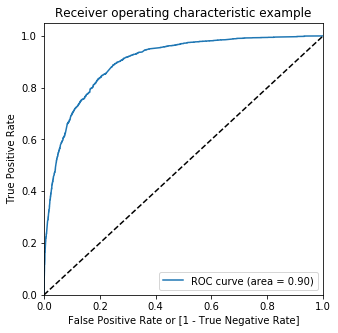

In [191]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

### Step 10: Finding Optimal Cutoff Point

In [192]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
3009,0,0.077719,3009,0,1,0,0,0,0,0,0,0,0,0
1012,0,0.013543,1012,0,1,0,0,0,0,0,0,0,0,0
9226,0,0.420681,9226,0,1,1,1,1,1,0,0,0,0,0
4750,1,0.708472,4750,1,1,1,1,1,1,1,1,1,0,0
7987,1,0.800536,7987,1,1,1,1,1,1,1,1,1,1,0


In [193]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
   
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.385136  1.000000  0.000000
0.1   0.1  0.670288  0.975061  0.479385
0.2   0.2  0.780507  0.922322  0.691677
0.3   0.3  0.804755  0.879804  0.757746
0.4   0.4  0.819399  0.795176  0.834571
0.5   0.5  0.823335  0.724448  0.885275
0.6   0.6  0.817824  0.668029  0.911652
0.7   0.7  0.797985  0.566231  0.943150
0.8   0.8  0.766179  0.443581  0.968246
0.9   0.9  0.722091  0.302535  0.984891


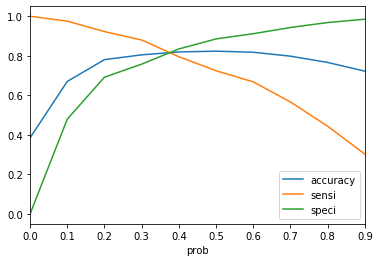

In [194]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.4 is the optimum point to take it as a cutoff probability.

In [195]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.4 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
3009,0,0.077719,3009,0,1,0,0,0,0,0,0,0,0,0,0
1012,0,0.013543,1012,0,1,0,0,0,0,0,0,0,0,0,0
9226,0,0.420681,9226,0,1,1,1,1,1,0,0,0,0,0,1
4750,1,0.708472,4750,1,1,1,1,1,1,1,1,1,0,0,1
7987,1,0.800536,7987,1,1,1,1,1,1,1,1,1,1,0,1


In [196]:
# overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8193985199181232

In [197]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3259,  646],
       [ 501, 1945]], dtype=int64)

In [198]:
TP = confusion2[1,1]
TN = confusion2[0,0] 
FP = confusion2[0,1]
FN = confusion2[1,0]

In [199]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7951757972199509

In [200]:
# Let us calculate specificity
TN / float(TN+FP)

0.8345710627400769

In [201]:
# Calculate false postive rate - 
print(FP/ float(TN+FP))

0.16542893725992316


In [202]:
# Positive predictive value 
print (TP / float(TP+FP))

0.7506754148977229


In [203]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8667553191489362


In [204]:
#Precision
TP/float(TP+FP)

0.7506754148977229

In [205]:
#Recall
TP/float(TP+FN)

0.7951757972199509

### Summary of the train modal
 ### Evaluation Result
   ##### Accuracy :-82 %
   ##### Sensitivity :- 79%
   ##### Specificity :-83 %
   ##### Precision :-75 %
   ##### Recall :-79 %

### Precision and Recall curve

In [206]:
y_train_pred_final.Converted, y_train_pred_final.predicted

(3009    0
 1012    0
 9226    0
 4750    1
 7987    1
        ..
 367     0
 82      1
 8199    0
 7077    0
 5754    0
 Name: Converted, Length: 6351, dtype: int64, 3009    0
 1012    0
 9226    0
 4750    1
 7987    1
        ..
 367     0
 82      1
 8199    1
 7077    1
 5754    0
 Name: predicted, Length: 6351, dtype: int64)

In [207]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

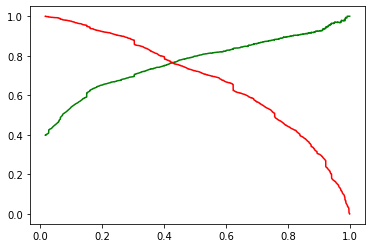

In [208]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Step 11: Making predictions on the test set

In [209]:
X_test[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']] = scaler.fit_transform(X_test[['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']])

In [210]:
X_test=X_test[col]
X_test.head()

,Do Not Email,Total Time Spent on Website,Newspaper Article,Newspaper,Lead Origin_Landing Page Submission,Lead Origin_Other Lead Origin,Lead Source_Olark Chat,Last Activity_Olark Chat Conversation,Last Activity_SMS Sent,What is your current occupation_Unemployed,Lead Profile_Others,Lead Profile_Potential Lead,Last Notable Activity_Modified
3271,0,-0.591008,0,0,0,0,0,0,0,0,1,0,0
1490,0,1.894051,0,0,1,0,0,0,0,0,0,1,0
7936,0,-0.743117,0,0,0,0,0,0,0,0,1,0,0
4216,0,-0.878732,0,0,0,1,0,0,0,0,0,0,1
3830,0,-0.578179,0,0,1,0,0,0,0,0,1,0,0


In [211]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.shape

(2723, 14)

In [212]:
y_test_pred = res.predict(X_test_sm)

In [213]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2470.0
Date:                Mon, 20 Jul 2020   Deviance:                       4940.0
Time:                        11:20:17   Pearson chi2:                 6.19e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.5388      0.151      3.577      0.000       0.244       0.834
Do Not Email                                  -1.3871      0.176     -7.889      0.000      -1.732      -1.043
Total Time Spent on Website                    1.1253      0.042     26.749      0.000       1.043       1.208
Newspaper Article                              1.7865      1.492      1.197      0.231      -1.138       4.711
Newspaper                                    -21.9165   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Lead Origin_Landing Page Submission           -0.3855      0.093     -4.166      0.000      -0.567      -0.204
Lead Origin_Other Lead Origin                  3.1409      0.195     16.138      0.000       2.759       3.522
Lead Source_Olark Chat                         1.1752      0.126      9.301      0.000       0.928       1.423
Last Activity_Olark Chat Conversation         -1.0132      0.175     -5.794      0.000      -1.356      -0.670
Last Activity_SMS Sent                         1.3322      0.078     17.157      0.000       1.180       1.484
What is your current occupation_Unemployed    -1.5440      0.134    -11.545      0.000      -1.806      -1.282
Lead Profile_Others                           -2.4467      0.151    -16.199      0.000      -2.743      -2.151
Lead Profile_Potential Lead                    1.6258      0.103     15.826      0.000       1.424       1.827
Last Notable Activity_Modified                -0.8222      0.084     -9.803      0.000      -0.987      -0.658
==============================================================================================================
"""

In [214]:
y_test_pred[:10]

3271    0.070899
1490    0.980362
7936    0.060419
4216    0.866305
3830    0.050019
1800    0.720508
6507    0.314029
4821    0.274262
4223    0.922662
4714    0.229435
dtype: float64

In [215]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [216]:
y_pred_1.head()

,0
3271,0.070899
1490,0.980362
7936,0.060419
4216,0.866305
3830,0.050019


In [217]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [218]:
# Putting CustID to index
y_test_df['Prospect ID'] = y_test_df.index

In [219]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [220]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [221]:
y_pred_final.head()

,Converted,Prospect ID,0
0,0,3271,0.070899
1,1,1490,0.980362
2,0,7936,0.060419
3,1,4216,0.866305
4,0,3830,0.050019


In [222]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [223]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['Prospect ID','Converted','Converted_Prob'], axis=1)

In [224]:
y_pred_final.head()

,Prospect ID,Converted,Converted_Prob
0,3271,0,0.070899
1,1490,1,0.980362
2,7936,0,0.060419
3,4216,1,0.866305
4,3830,0,0.050019


In [225]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.4 else 0)

In [226]:
y_pred_final.head()

,Prospect ID,Converted,Converted_Prob,final_predicted
0,3271,0,0.070899,0
1,1490,1,0.980362,1
2,7936,0,0.060419,0
3,4216,1,0.866305,1
4,3830,0,0.050019,0


In [227]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.8141755416819684

In [228]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1443,  291],
       [ 215,  774]], dtype=int64)

In [229]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [230]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.782608695652174

In [231]:
# Let us calculate specificity
TN / float(TN+FP)

0.8321799307958477

In [232]:
## precision
TP/float(TP+FP)

0.7267605633802817

In [233]:
## RECALL
TP/float(TP+FN)

0.782608695652174

### Summary of the Test modal
 ### Evaluation Result
   ##### Accuracy :-81 %
   ##### Sensitivity :- 78 %
   ##### Specificity :-83 %
   ##### Precision :-72 %
   ##### Recall :-78 %

## Conclusion

- From the train and test model  evaluation - we can infer that all Accuracy,Sensitivity & specificity are  all close to each other- which determines the ROC cut off - 0.4 is good.
- And also we can see all the variables P values ate <0.5 which are more significant. 
- And also VIF  values of all the variables are < 5 , which is also more significant.

- _ve coefficient values variables - has less percentage of chance of probability of lead  getting converted.
- +ve coefficient values variables - has high percentage of chance of probability of lead  getting converted.

High Chance of getting lead to converted variables  are listed below with their co-efficient value.

#### Lead Origin_Other Lead Origin : Coefficient values = 3.1409 times of Lead origin probability of lead getting converted.  
#### Newspaper Article : Coefficient values = 1.7885 times of Newspaper Article probability of lead getting converted.
#### Lead Profile_Potential Lead : Coefficient values = 1.6258 times of Lead origin probability of lead getting converted .

Overall, the Company should concentrate on the above variables to increase the number of leads  percentage.